# Import dependencies

In [1]:
import os
import time
import pandas
import pickle
import numpy as np

import matplotlib.pyplot as plt

import pickle

!pip install tensorflow-gpu==2.3.1
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

tf.compat.v1.disable_eager_execution()

print(tf.__version__)

     |████████████████████████████████| 320.4 MB 22 kB/s 
     |████████████████████████████████| 459 kB 18.2 MB/s 
     |████████████████████████████████| 2.9 MB 34.8 MB/s 
     |████████████████████████████████| 20.1 MB 46.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

2.3.1


# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = '/content/drive/My Drive/vae-speech'

spec = np.load(dir + '/male_spec.npy', allow_pickle=True)
frt = np.load(dir + '/male_frt.npy', allow_pickle=True)
f0 = np.load(dir + '/male_f0.npy', allow_pickle=True)

print(spec.shape)
print(frt.shape)
print(f0.shape)

(2489, 513, 63)
(2489, 438)
(2489, 197)


# Prepare data

In [4]:
def update_dimension():
  new_spec = []

  for idx, wav in enumerate(spec):
    d = np.delete(spec[idx], -1, axis=0)
    z = np.zeros((len(d), 1))
    d = np.append(d, z, axis = 1)
    new_spec.append(d)

  return np.array(new_spec)

In [5]:
nd = update_dimension()
n = len(nd)

#reshape the data
nd = np.reshape(nd, (n, 512, 64, 1))
nf = np.reshape(frt, (n, len(frt[0]), 1))
ns = np.reshape(f0, (n, len(f0[0]), 1))

x_train_spec = nd[:int(0.6*n)]
x_test_spec = nd[int(-0.4*n):]

x_train_frt = nf[:int(0.6*n)]
x_test_frt = nf[int(-0.4*n):]

x_train_f0 = ns[:int(0.6*n)]
x_test_f0 = ns[int(-0.4*n):]

print("new spec dimension: " + str(x_train_spec.shape))
print("new f0 dimension: " + str(x_train_f0.shape))
print("new formant dimension: " + str(x_train_frt.shape))
print("training size: " + str(len(x_train_spec)))
print("testing size: " + str(len(x_test_spec)))

new spec dimension: (1493, 512, 64, 1)
new f0 dimension: (1493, 197, 1)
new formant dimension: (1493, 438, 1)
training size: 1493
testing size: 995


# Model generation

# VAE

In [6]:
shape = 1

learning_rate = 0.001 #@param {type:"raw"}
num_epochs_to_train = 30 #@param {type:"integer"}
batch_size = 32 #@param {type:"integer"}
vector_dimension = 64 #@param {type:"integer"}

sampling_rate = 16000 #@param {type:"integer"}

In [62]:
class VAE:
  def __init__(self,
               model_type,
               foi_input,
               model_input,
               foi_shape,
               conv_filters, #convolutional network filters
               conv_kernels, #convNet kernel size
               conv_strides, #convNet strides
               latent_space_dim):
    self.model_type = model_type
    self.foi_input = foi_input
    self.model_input = model_input
    self.foi_shape = foi_shape
    self.conv_filters = conv_filters # is a list for each layer, i.e. [2, 4, 8]
    self.conv_kernels = conv_kernels # list of kernels per layer, [1, 2, 3]
    self.conv_strides = conv_strides # stride for each filter [1, 2, 2], note: 2 means you are downsampling the data in half
    self.latent_space_dim = latent_space_dim # how many neurons on bottleneck
    self.loss_weight = 1000000

    self.mlp = None
    self.encoder = None
    self.decoder = None
    self.model = None
    self.hist = None

    self.vae_output = None
    self.mlp_output = None

    self._num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None

    self._build()

  def summary(self):
    self.encoder.summary()
    print("\n")
    self.decoder.summary()
    print("\n")
    self.model.summary()

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_mlp()
    self._build_autoencoder()
    self._add_model_loss()

  def _add_model_loss(self):
    kl_loss = self._calculate_kl_loss(self.model_input, self.vae_output)
    reconstruction_loss = self._calculate_reconstruction_loss(self.model_input, self.vae_output)
    feature_loss = self._calculate_foi_loss(self.foi_input, self.mlp_output)

    combined_loss = kl_loss + self.loss_weight * (reconstruction_loss + feature_loss)
    self.model.add_loss(combined_loss)
    self.model.add_metric(combined_loss, name=f"{self.model_type}_combined_loss", aggregation='mean')

  def _calculate_foi_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=0)
    return reconstruction_loss
  
  def _calculate_reconstruction_loss(self, y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

  def _calculate_kl_loss(self, y_target, y_predicted):
    kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                          K.exp(self.log_variance), axis=1)
    return kl_loss

  #----------------FULL MODEL-----------------#
  def _build_autoencoder(self):
    model_input = self.model_input
    feature_input = self.foi_input
    self.vae_output = self.decoder(self.encoder(model_input))
    self.mlp_output = self.mlp(self.encoder(model_input))
    self.model = Model([model_input, feature_input], 
                       [self.vae_output, self.mlp_output], 
                       name=f"{self.model_type}_autoencoder")

  #----------------MLP-----------------#
  def _build_mlp(self):
    mlp_input = self._add_mlp_input()
    mlp_output = self._add_mlp_layers(mlp_input)
    self.mlp = Model(mlp_input, mlp_output, name=f"MLP_{self.model_type}_model")

  def _add_mlp_input(self):
    return Input(shape=self.latent_space_dim, name=f"{self.model_type}_mlp_input")

  def _add_mlp_layers(self, mlp_input):
    num_neurons = np.prod(self._shape_before_bottleneck)
    d_layer = Dense(num_neurons, activation='relu', name=f"MLP_{self.model_type}_layer1")(mlp_input)
    o_layer = Dropout(0.45, name=f"MLP_{self.model_type}_dropout1")(d_layer)
    d_layer = Dense(512, activation='relu', name=f"MLP_{self.model_type}_layer2")(o_layer)
    o_layer = Dropout(0.45, name=f"MLP_{self.model_type}_dropout2")(d_layer)
    d_layer = Dense(self.foi_shape, activation='softmax', name=f"MLP_{self.model_type}_layer3")(o_layer)
    r_layer = Reshape((self.foi_shape, 1), name=f"MLP_{self.model_type}_reshape")(d_layer)
    return r_layer

  #----------------DECODER-----------------#
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name=f"{self.model_type}_decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name=f"{self.model_type}_decoder_input")

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck) # [ 1, 2, 4] -> 8
    dense_layer = Dense(num_neurons, name=f"{self.model_type}_decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters=self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name=f"{self.model_type}_decoder_conv_transpose_layer_{layer_num}"
    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"{self.model_type}_decoder_relu_{layer_num}")(x)
    x = BatchNormalization(name=f"{self.model_type}_decoder_bn_{layer_num}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1,
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name=f"{self.model_type}decoder_conv_transpose_layer_{self._num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name=f"{self.model_type}_sigmoid_output_layer")(x)
    return output_layer

  #----------------ENCODER-----------------#
  def _build_encoder(self):
    conv_layers = self._add_conv_layers(self.model_input)
    bottleneck =  self._add_bottleneck(conv_layers)
    self.encoder = Model(self.model_input, bottleneck, name=f"{self.model_type}_encoder")

  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x
  
  def _add_conv_layer(self, layer_index, x):
    """
    Adds a convolutional block to a graph of layers, consisting
    of Conv 2d + ReLu activation + batch normalization.
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters= self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = "same",
        name = f"{self.model_type}_encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = ReLU(name=f"{self.model_type}_encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name=f"{self.model_type}_encoder_bn_{layer_number}")(x)
    return x

  #-------------LATTENT SPACE-------------#
  def _add_bottleneck(self, x):
    """Flatten data and add bottleneck with Gaussian sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.latent_space_dim,name="mu")(x)
    self.log_variance = Dense(self.latent_space_dim,
                              name=f"{self.model_type}_log_variance")(x)
    
    def sample_point_from_normal_distribution(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean=0., stddev=1.)
      sampled_point = mu + K.exp(log_variance / 2) * epsilon

      return sampled_point

    x = Lambda(sample_point_from_normal_distribution, 
              name=f"{self.model_type}_encoder_output")([self.mu, self.log_variance])
    return x

# Model training

In [63]:
def generate_model(model_input, foi_input, foi_shape, model_type):
  vae = VAE(
      model_type = model_type,
      foi_input = foi_input,
      model_input = model_input,
      foi_shape = foi_shape,
      conv_filters=(512, 256, 128, 64, 32),
      conv_kernels=(3, 3, 3, 3, 3),
      conv_strides=(2, 2, 2, 2, (2,1)),
      latent_space_dim = vector_dimension
  )
  return vae

In [64]:
def calculate_reconstruction_loss(y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

f0_input = Input(shape=(197, 1), name='f0_input')
frt_input = Input(shape=(438, 1), name='formant_input')
model_input = Input(shape=(512, 64, 1), name="model_input")

vae_f0 = generate_model(model_input, f0_input, 197, "f0")
vae_frt = generate_model(model_input, frt_input, 438, "frt")

model = Model(inputs=[model_input, f0_input, frt_input], outputs=[vae_f0.vae_output, vae_frt.vae_output])

log_loss = calculate_reconstruction_loss(model_input, vae_f0.vae_output + vae_frt.vae_output)
model.add_loss(log_loss)
model.add_metric(log_loss, name='log reconstruction', aggregation='mean')

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer)

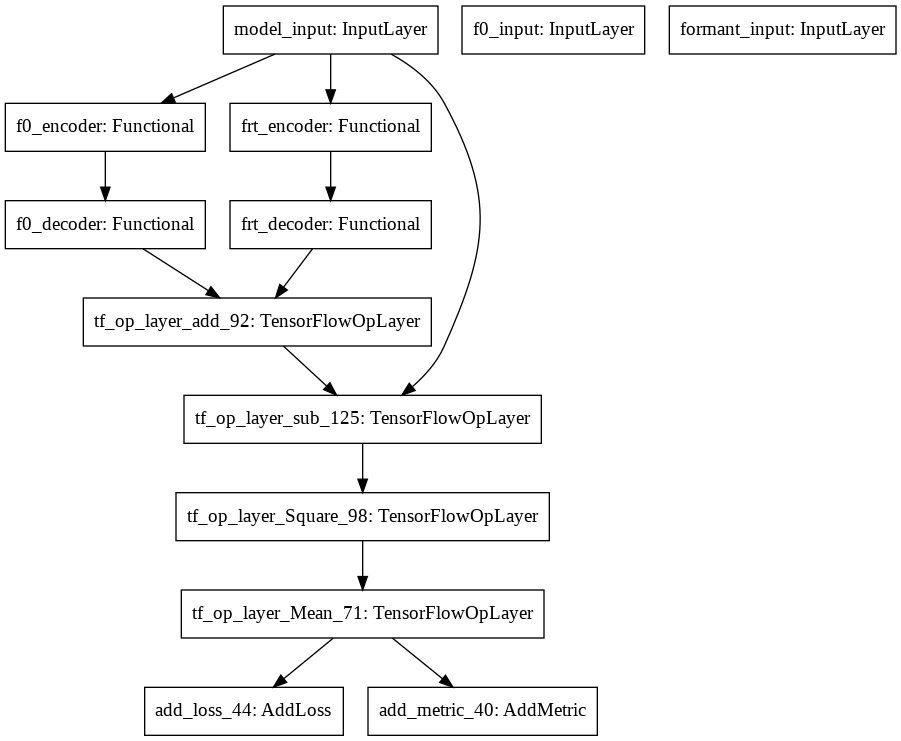

In [65]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit([x_train_spec, x_train_f0, x_train_frt],
          batch_size=batch_size,
          epochs=num_epochs_to_train)

In [ ]:
def get_time_stamp():
  secondsSinceEpoch = time.time()
  timeObj = time.localtime(secondsSinceEpoch)
  x = ('%d_%d_%d_%d%d' % (timeObj.tm_mday, timeObj.tm_mon, timeObj.tm_year, timeObj.tm_hour, timeObj.tm_min))
  return x

def save(model, save_folder):
    create_folder_if_it_doesnt_exist(save_folder)
    save_weights(model, save_folder)

def create_folder_if_it_doesnt_exist(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def save_weights(model, save_folder):
    save_path = os.path.join(save_folder, "weights.h5")
    model.save_weights(save_path)

save_dir = '/content/drive/My Drive/vae-speech/'
current_time = get_time_stamp()

save(vae_f0.model, f"{save_dir}f0_{current_time}_z{vector_dimension}")
save(vae_frt.model, f"{save_dir}frt_{current_time}_z{vector_dimension}")
save(model, f"{save_dir}full_{current_time}_z{vector_dimension}")

In [ ]:
def plot_specgram(spec, sample_rate, title="Spectrogram", xlim=None):
  spec = np.reshape(spec, (512, 64))
  num_freq, num_frames = spec.shape
  time_axis = np.arange(0, num_frames) / sample_rate
  freq_axis = np.arange(0, num_freq) * sample_rate/2/num_freq
  figure, axes = plt.subplots(1, 1)
  axes.pcolormesh(time_axis, freq_axis, spec[:,:], cmap='viridis')
  axes.set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

decoded_specgram = model.predict([x_test_spec, x_test_f0, x_test_frt])

plot_specgram(x_test_spec[0], sampling_rate)
plot_specgram(decoded_specgram[0], sampling_rate)